# Musical Chord Classification

## Business Understanding

This project addresses the challenge of accurately identifying musical chords as either major or minor using audio input. Manual chord transcription can be time-consuming and requires a solid grasp of music theory. By leveraging machine learning and audio processing techniques, this tool automates chord classification, providing real-time results that are valuable to musicians, music producers, and educators.

### Stakeholders:

- **Musicians** can use the tool to quickly identify chords during practice or live performances, enhancing learning and improvisation.
- **Music Producers** benefit from real-time chord analysis, streamlining the composition and arrangement process.
- **Educators** gain an interactive way to teach chord progressions and musical theory, helping students grasp harmonic relationships more effectively.

### Conclusion:

The model achieved 98% accuracy by utilizing data augmentation to balance the dataset, originally skewed towards major chords (502 major, 357 minor). Augmenting 143 minor chord samples created a more even distribution, improving classification performance. This tool has the potential to save time and improve the workflow for musicians, producers, and educators by automating chord recognition, making it more accessible and efficient.


### Tools and Methodologies used:
- **Audio feature extraction**: `librosa`, `scipy`
- **Data manipulation**: `numpy`, `pandas`
- **Visualization**: `matplotlib`, `IPython.display`
- **Machine Learning**: `scikit-learn`
- **Dataset management**: `Kaggle API`
- **Warning suppression**: `warnings` module

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import itertools
import warnings
import json
import os

# Audio feature extraction
import librosa
from scipy.signal import find_peaks

# Kaggle API for dataset download
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.fft import fft
from scipy.io import wavfile

# Machine learning models and utilities
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier


# Ignore warnings from specific modules
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa")
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", message="Couldn't find ffmpeg or avconv")

## Data Understanding

The dataset used for this project is the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset from Kaggle. It consists of .wav audio files, containing major and minor chords played on guitar and piano. Since the dataset is readily available, it eliminates the need for manual data collection. The clear distinction between major and minor chords makes it highly suitable for this classification task.

### Dataset Size and Features:

#### Size: 
> The dataset contains 859 audio samples—502 major chords and 357 minor chords. To balance the dataset, we applied augmentation, adding 143 minor chord samples, resulting in 500 samples for each class.

#### Features: 
> While earlier iterations explored features such as Mel-frequency cepstral coefficients (MFCCs), Chroma, Spectral centroid, zero-crossing rate, and Mel-spectrograms, the final model focuses exclusively on harmonic content. Specifically, harmonic ratios were extracted and analyzed to capture the major/minor third distinction. These selected harmonic ratios were identified both visually and through statistical analysis, with a p-value < 0.05, indicating their statistical significance in distinguishing between major and minor chords.

The experimental exploration of other features and iterations can be found in the accompanying `workbook.ipynb`, but the final model is built solely on harmonic extraction and analysis.

### Harmonic Ratio Features:

Harmonic ratios directly reflect the intervals between notes in a chord, which is the key distinction between major and minor chords. The visually and statistically significant harmonic ratios make this approach highly relevant for the classification task, focusing precisely on the differences between the two chord types.

#### Data Limitations:

One limitation of the dataset is its restriction to two instruments: guitar and piano. This limits the model's applicability to other instruments, as the harmonic content of chords can vary with timbre. Additionally, the dataset lacks variation in dynamics and playing styles, which might affect chord recognition in diverse musical contexts. Therefore, while the model performs well on this dataset, its generalization to other instruments or more complex real-world music may be limited.

In [2]:
# uncomment if replicating project
# !pip install kaggle

In [3]:
def authenticate_kaggle_api(api_config_path: str = 'kaggle.json'):
    """
    Authenticate Kaggle API to allow dataset download.

    Parameters:
    api_config_path (str): Path to Kaggle API configuration file.
    """
    with open(api_config_path, 'r') as f:
        kaggle_config = json.load(f)

    os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
    os.environ['KAGGLE_KEY'] = kaggle_config['key']

    api = KaggleApi()
    api.authenticate()
    return api

# Initialize Kaggle API and download dataset
def download_dataset(api, dataset_name: str, destination_dir: str):
    """
    Download and extract the dataset using Kaggle API.

    Parameters:
    api: KaggleApi instance.
    dataset_name (str): Name of the dataset to download.
    destination_dir (str): Directory to save the dataset.
    """
    os.makedirs(destination_dir, exist_ok=True)
    api.dataset_download_files(dataset_name, path=destination_dir, unzip=True)
    print("Dataset downloaded and extracted to:", destination_dir)

In [4]:
# Authenticate and download Kaggle dataset
api = authenticate_kaggle_api()
dataset_dir = os.path.join(os.getcwd(), 'dataset')
download_dataset(api, 'deepcontractor/musical-instrument-chord-classification', dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [5]:
def load_audio_file_details(base_dir: str) -> pd.DataFrame:
    """
    Load details of audio files from specified directory.

    Parameters:
    base_dir (str): Base directory containing audio files.

    Returns:
    pd.DataFrame: DataFrame containing file paths, ids, and labels.
    """
    file_details = []
    for category in ['Major', 'Minor']:
        category_dir = os.path.join(base_dir, category)
        for filename in os.listdir(category_dir):
            if filename.endswith('.wav'):
                file_details.append({'path': os.path.join(category_dir, filename), 'id': filename, 'label': category})
    return pd.DataFrame(file_details)

In [6]:
base_dir = os.path.join(dataset_dir, 'Audio_Files')
file_data = load_audio_file_details(base_dir)
print(file_data.head())

                                                path             id  label
0  C:\Users\Nik\Desktop\code\Flatiron\capstone\da...    Major_0.wav  Major
1  C:\Users\Nik\Desktop\code\Flatiron\capstone\da...    Major_1.wav  Major
2  C:\Users\Nik\Desktop\code\Flatiron\capstone\da...   Major_10.wav  Major
3  C:\Users\Nik\Desktop\code\Flatiron\capstone\da...  Major_100.wav  Major
4  C:\Users\Nik\Desktop\code\Flatiron\capstone\da...  Major_101.wav  Major


## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

The standard practice in determining the closest note to a given frequency generally involves finding which standard note frequency it's nearest to.

#### Harmonics

A single note played on an instrument does not produce just one frequency. For example, playing an 'A' at 220 Hz will generate additional frequencies at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. According to this [Music Note Frequency Chart](https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/) the frequencies 220, 440, and 880 Hz correspond to the musical notes A3, A4, and A5, respectively. These notes are all 'A' notes, each one octave apart. The lowest harmonic, known as the fundamental frequency, determines the perceived pitch of the sound.

> In standard musical pitch, A4, or the fourth octave 'A', is tuned to 440 Hz.

Interestingly, the frequency 1100 Hz falls between the frequencies for B5 (987.77 Hz) and C6 (1046.50 Hz). Calculating the midpoint between these two frequencies gives:

$$
\text{Midpoint} = \frac{987.77 \, \text{Hz} + 1046.50 \, \text{Hz}}{2} = 1017.135 \, \text{Hz}
$$

Since 1100 Hz is closer to 1046.50 Hz than to 987.77 Hz, it would be classified closer to C6 in standard musical pitch, though it is somewhat sharper than a typical B5. This illustrates how harmonics work in physical instruments, where playing a fundamental note also produces these higher frequencies, contributing to the richness of the instrument's sound.

#### Chords

A chord represents a combination of several notes played simultaneously, resulting in a harmonious sound. This harmony is achieved through the specific relationship of the frequencies of the notes within the chord. For instance, a simple major chord is composed of the root note, a major third above the root, and a perfect fifth above the root, creating a full and bright sound typically associated with major chords.

Minor chords, on the other hand, are formed by the root note, a minor third above the root, and a perfect fifth above the root, delivering a more melancholic or somber tone compared to major chords.

In addition to major and minor chords, two other common types are diminished and augmented chords. A diminished chord is made up of the root note, a minor third, and a diminished fifth, giving it a tense and unstable sound. An augmented chord consists of the root note, a major third, and an augmented fifth, which creates a sense of suspense or unresolved tension.

#### FourierTransforms

A Fourier transform is a powerful mathematical tool that transforms a signal from its original domain (often time or space) into a frequency domain. This transformation allows us to dissect complex signals and understand how different frequencies contribute to the overall signal. Essentially, it breaks down a wave-like signal into its individual components, highlighting the frequencies that are present.

Why does this help us? Well, by using a Fourier transform, we can analyze various aspects of signals that are not immediately apparent in the time domain. For example, in music production, it helps us identify the specific frequencies that make up a sound, which is crucial for tasks like mixing, mastering, or even sound design. This analysis provides insights into the pitch, tone, and timbre of sounds, helping audio engineers and musicians make informed decisions to enhance musical pieces.

In essence, the Fourier transform is a bridge between the time domain and the frequency domain, providing a comprehensive look at the frequencies that influence a signal. This capability makes it an indispensable tool in fields ranging from audio processing to telecommunications and beyond.

Using a frequency chart to analyze these chords would reveal a complex spectrum due to the concurrent presence of multiple notes. Each note in a chord contributes its fundamental frequency along with its harmonics, leading to a dense array of spikes on the chart. This complex interplay of frequencies helps to understand why chords have their distinctive sounds and emotional impacts.

In [7]:
from IPython.display import Audio
from pydub import AudioSegment
from pydub.playback import play
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

class AudioAnalyzer:
    def __init__(self, df):
        self.df = df

    def play_audio(self, file_id):
        """
        Finds the file path from the file_id, loads, and plays the audio or displays a player.
        
        Parameters:
        file_id (str): The filename (e.g., 'Major_123.wav').
        """
        # Find the row in the DataFrame with the matching file_id
        file_row = self.df[self.df['id'] == file_id]
        
        if not file_row.empty:
            # Get the full path of the audio file
            file_path = file_row.iloc[0]['path']
            
            try:
                print(f"Playing audio: {file_path}")
                # Display an embedded audio player in Jupyter (rather than just playing it)
                return Audio(filename=file_path, autoplay=False)
            except Exception as e:
                print(f"Error playing audio: {e}")
        else:
            print(f"File with id {file_id} not found in file_data.")

    def plot_audio(self, file_id, max_freq=None):
        """
        Plots the time and frequency domain of the audio file.
        
        Parameters:
        file_id (str): The filename (e.g., 'Major_123.wav').
        max_freq (float): Maximum frequency to display in the frequency domain plot.
        """
        # Find the row in the DataFrame with the matching file_id
        file_row = self.df[self.df['id'] == file_id]

        if not file_row.empty:
            filename = file_row.iloc[0]['path']
            
            # Read the audio file
            samplerate, data = wavfile.read(filename)
            times = np.arange(len(data)) / float(samplerate)
            
            # Plot time domain data
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.title("Time Domain")
            plt.xlabel("Time [s]")
            plt.ylabel("Amplitude")
            plt.plot(times, data)
            
            # Compute and plot frequency domain data
            fft_data = np.fft.fft(data)
            freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
            magnitude = np.abs(fft_data)[:len(data)//2]
            freqs = freqs[:len(data)//2]
            
            plt.subplot(1, 2, 2)
            plt.title("Frequency Domain")
            plt.xlabel("Frequency [Hz]")
            plt.ylabel("Magnitude")
            if max_freq is not None:
                plt.xlim([0, max_freq])
            plt.plot(freqs, magnitude)
            plt.show()
        else:
            print(f"File with id {file_id} not found in file_data.")


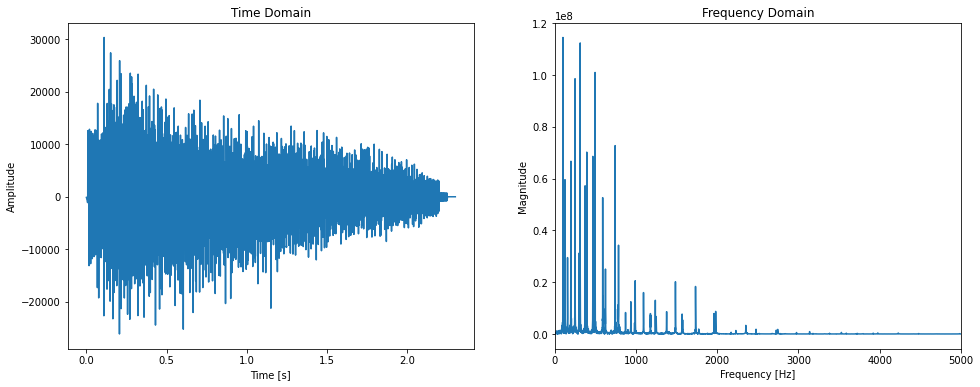

Playing audio: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_222.wav


In [8]:
analyzer = AudioAnalyzer(file_data)
file_id = "Major_222.wav"

# Plot the audio
analyzer.plot_audio(file_id, max_freq=5000)

# Play the audio
audio_player = analyzer.play_audio(file_id)
audio_player



## Data Preparation

The distinction between major and minor chords lies in the intervals between their constituent notes, particularly the major and minor third intervals. By analyzing the harmonics of audio signals, we can accurately capture these relationships, as the harmonics are directly tied to the frequencies that define the chord's structure.

The extraction functions were designed to isolate and analyze these harmonics using Fourier transforms, which break down the audio signal into its individual frequency components. This allows us to identify not just the fundamental frequencies, but also their harmonic overtones, giving a clear picture of the harmonic intervals that characterize each chord. The harmonic intervals and ratios extracted through these functions provide precise and relevant data for distinguishing between major and minor chords, making this approach both targeted and effective for the problem at hand.

By using only the harmonic content for the final model, we focused on the core features essential to chord classification, ensuring both the relevance and efficiency of the feature extraction process.

### Feature Extraction

In [9]:
def find_harmonics(signal=None, sr=22050, n_fft=2048):
    try:
        if signal is None or len(signal) == 0:
            raise ValueError("No audio signal provided.")

        S = np.abs(librosa.stft(signal, n_fft=n_fft))
        magnitude = np.mean(S, axis=1)
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)
        harmonic_frequencies = positive_freqs[peaks]
        harmonic_intervals = np.diff(harmonic_frequencies) if len(harmonic_frequencies) > 1 else []

        return harmonic_frequencies, harmonic_intervals

    except Exception as e:
        print(f"Error processing harmonics for augmented signal: {e}")
        return None, None

In [10]:
def extract_audio_signal(path, sr=None):
    try:
        signal, sr = librosa.load(path, sr=sr)
        return signal, sr
    except Exception as e:
        print(f"Error loading audio from {path}: {e}")
        return None, None


#### Running Feature Extraction on Origional Dataset

In [11]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            # Extract features based on toggles
            if feature_toggles.get('chroma', False):
                feature_dict.update({'chroma': extract_audio_features(signal, sr)['chroma']})
            if feature_toggles.get('mfcc', False):
                feature_dict.update({'mfcc': extract_audio_features(signal, sr)['mfcc']})
            if feature_toggles.get('spectral_centroid', False):
                feature_dict['spectral_centroid'] = extract_audio_features(signal, sr)['spectral_centroid']
            if feature_toggles.get('zero_crossing_rate', False):
                feature_dict['zero_crossing_rate'] = extract_audio_features(signal, sr)['zero_crossing_rate']
            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                feature_dict['harmonics'] = harmonics
                feature_dict['intervals'] = intervals
            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            # Extract comprehensive harmonic ratios for major/minor classification
            if feature_toggles.get('harmonic_ratios', False):
                harmonic_ratios = extract_comprehensive_harmonic_ratios(signal, sr)
                feature_dict.update(harmonic_ratios)

            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [12]:
# Feature Toggles
feature_toggles = {
    'chroma': False,
    'mfcc': False,
    'spectral_centroid': False,
    'zero_crossing_rate': False,
    'harmonics': True,
    'mel_spectrogram': False,
}

# Extract Features for All Data
raw_features_df = extract_features_from_signals(file_data, feature_toggles)
raw_features_df['id'] = raw_features_df['id'].str.replace('.wav', '', regex=False)
raw_features_df['Label'] = raw_features_df['Label'].str.lower()

# Display Resulting DataFrame
print("Extracted Features DataFrame:")
print(raw_features_df.head())

Error loading audio from C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame:
          id  Label                                       audio_signal  \
0    Major_0  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100  major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           harmonics  \
0  [258.1463414634146, 387.2195121951219, 516.292...   
1  [387.2195121951219, 516.2926829268292, 645.365...   
2  [258.1463414634146, 387.2195121951219, 516.292...   
3  [301.1707317073171, 387.2195121951219, 602.341...   
4  [301.1707317073171, 387.2195121951219, 688.390...   

                                           intervals  
0  [129.0731707317073,

## Augmenting Data

We will augment the audio data using techniques such as time-stretching, pitch-shifting, and adding noise. The augmented data will then have features extracted in the same way as the original data. We will apply these augmentations to our data to create synthetic data - to even the distribution of our classes.

In [13]:
# Augmentation functions
def pitch_shift(signal, sr, n_steps=4):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def augment_audio(signal, sr):
    augmentations = ['time_stretch', 'pitch_shift', 'add_noise']
    augmentation = random.choice(augmentations)

    if augmentation == 'time_stretch':
        return librosa.effects.time_stretch(signal, rate=1.2)
    elif augmentation == 'pitch_shift':
        return pitch_shift(signal, sr, n_steps=4)
    elif augmentation == 'add_noise':
        return add_noise(signal)
    else:
        return signal

In [14]:
# Count existing samples in the original dataset
original_counts = file_data['label'].value_counts()
target_count = 500

# Determine how many samples to augment for each class
augmented_counts = {label: target_count - count if count < target_count else 0 for label, count in original_counts.items()}


In [15]:
def extract_features_from_signals(data, feature_toggles):
    """
    Extract features from audio signals in a DataFrame.

    Parameters:
    data (pd.DataFrame): DataFrame containing audio file details.
    feature_toggles (dict): Dictionary specifying which features to extract.

    Returns:
    pd.DataFrame: DataFrame containing extracted features.
    """
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip to next if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                if harmonics is not None:
                    feature_dict['harmonics'] = harmonics
                if intervals is not None:
                    feature_dict['intervals'] = intervals
                    
            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [16]:
# Feature Toggles for Augmented Data
feature_toggles = {
    'chroma': False,
    'mfcc': False,
    'spectral_centroid': False,
    'zero_crossing_rate': False,
    'harmonics': True,
    'mel_spectrogram': False
}

# Extract Features for Augmented Data
augmented_features_df = extract_features_from_signals(file_data, feature_toggles)

# Replace NaN values with 0 in augmented_features_df
augmented_features_df.fillna(0, inplace=True)

# Clean 'id' and 'Label' columns
augmented_features_df['id'] = augmented_features_df['id'].str.replace('.wav', '', regex=False)
augmented_features_df['Label'] = augmented_features_df['Label'].str.lower().str.strip()  # Ensure labels are lowercase and stripped of spaces

# Display Resulting DataFrame
print("Extracted Features DataFrame (Cleaned Augmented Data):")
print(augmented_features_df.head())

Error loading audio from C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame (Cleaned Augmented Data):
          id  Label                                       audio_signal  \
0    Major_0  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100  major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           harmonics  \
0  [258.1463414634146, 387.2195121951219, 516.292...   
1  [387.2195121951219, 516.2926829268292, 645.365...   
2  [258.1463414634146, 387.2195121951219, 516.292...   
3  [301.1707317073171, 387.2195121951219, 602.341...   
4  [301.1707317073171, 387.2195121951219, 688.390...   

                                           intervals

### Feature Engineering

#### Ratios Between Specific Harmonics

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

In [17]:
def expand_features(df, features_to_expand):
    expanded_df = df.copy()
    for feature in features_to_expand:
        if feature in df.columns:
            # Expand each list/array into separate columns with appropriate prefix
            expanded_features = pd.DataFrame(df[feature].tolist(), index=df.index)
            expanded_features.columns = [f'{feature}_{i+1}' for i in range(expanded_features.shape[1])]
            # Add the expanded columns to the original dataframe and drop the original
            expanded_df = pd.concat([expanded_df, expanded_features], axis=1).drop(columns=[feature])
    return expanded_df

# Expand harmonics and intervals in the raw data
features_to_expand = ['harmonics', 'intervals']
expanded_raw_features_df = expand_features(raw_features_df, features_to_expand)

print("Available Columns in Expanded DataFrame:")
print(expanded_raw_features_df.columns)

Available Columns in Expanded DataFrame:
Index(['id', 'Label', 'audio_signal', 'harmonics_1', 'harmonics_2',
       'harmonics_3', 'harmonics_4', 'harmonics_5', 'harmonics_6',
       'harmonics_7', 'harmonics_8', 'harmonics_9', 'harmonics_10',
       'harmonics_11', 'harmonics_12', 'harmonics_13', 'harmonics_14',
       'harmonics_15', 'harmonics_16', 'harmonics_17', 'harmonics_18',
       'harmonics_19', 'harmonics_20', 'harmonics_21', 'intervals_1',
       'intervals_2', 'intervals_3', 'intervals_4', 'intervals_5',
       'intervals_6', 'intervals_7', 'intervals_8', 'intervals_9',
       'intervals_10', 'intervals_11', 'intervals_12', 'intervals_13',
       'intervals_14', 'intervals_15', 'intervals_16', 'intervals_17',
       'intervals_18', 'intervals_19', 'intervals_20'],
      dtype='object')


In [18]:
# Copy the raw features dataframe
features_df = raw_features_df.copy()

# Standardized Function to Extract Harmonic Ratios
def extract_harmonic_ratios_standardized(df):
    harmonic_ratios = []
    for idx, row in df.iterrows():
        ratios = {}
        harmonics = row['harmonics']

        # Ensure harmonics is a list or array and contains more than one value
        if isinstance(harmonics, (list, np.ndarray)) and len(harmonics) > 1:
            # Use itertools.combinations to get all pairs (i, j) with i < j
            for i, j in itertools.combinations(range(len(harmonics)), 2):
                # Always use the lower index as the denominator to ensure consistency
                if harmonics[i] > 1e-6:  # Avoid division by zero or near-zero values
                    ratio_key = f'ratio_{i+1}_to_{j+1}'  # Naming convention: low index to high index
                    ratios[ratio_key] = harmonics[j] / harmonics[i]
                else:
                    ratios[ratio_key] = np.nan

        harmonic_ratios.append(ratios)
    
    # Convert harmonic ratios to DataFrame and ensure proper numeric type
    harmonic_ratios_df = pd.DataFrame(harmonic_ratios).apply(pd.to_numeric, errors='coerce')
    
    # Extract only the id and Label columns from the original dataframe
    id_label_df = df[['id', 'Label']].reset_index(drop=True)
    
    # Concatenate id, Label, and harmonic ratios into a new DataFrame
    ratios_df = pd.concat([id_label_df, harmonic_ratios_df.reset_index(drop=True)], axis=1)
    
    return ratios_df

# Apply the function to expand selected harmonic ratios (for evaluation)
features_with_ratios_df = extract_harmonic_ratios_standardized(features_df)

# Replace NaN values with 0 for simplicity in evaluation
features_with_ratios_df.fillna(0, inplace=True)

# Display a few rows for validation
print("Features DataFrame with Harmonic Ratios:")
print(features_with_ratios_df.head())

Features DataFrame with Harmonic Ratios:
          id  Label  ratio_1_to_2  ratio_1_to_3  ratio_1_to_4  ratio_1_to_5  \
0    Major_0  major      1.500000      2.000000      2.500000      3.000000   
1    Major_1  major      1.333333      1.666667      2.000000      2.555556   
2   Major_10  major      1.500000      2.000000      2.833333      3.666667   
3  Major_100  major      1.285714      2.000000      2.571429      3.142857   
4  Major_101  major      1.285714      2.285714      3.142857      3.714286   

   ratio_1_to_6  ratio_1_to_7  ratio_1_to_8  ratio_1_to_9  ...  \
0      4.000000      4.500000      5.166667      6.166667  ...   
1      3.000000      3.444444      5.111111      0.000000  ...   
2      4.333333      5.166667      5.500000      7.166667  ...   
3      3.714286      4.571429      5.142857      5.571429  ...   
4      4.142857      5.142857      0.000000      0.000000  ...   

   ratio_15_to_21  ratio_16_to_20  ratio_16_to_21  ratio_17_to_20  \
0             0.0 

In [19]:
# Filter Harmonic Ratios Based on Variance
def filter_low_variance_ratios(df, threshold=0.01):
    ratio_columns = [col for col in df.columns if 'ratio_' in col]
    selected_columns = []

    # Loop over each ratio column to calculate variance and filter
    for col in ratio_columns:
        variance = df[col].var()
        if variance > threshold:
            selected_columns.append(col)

    return selected_columns

# Select harmonic ratio columns with sufficient variance
selected_harmonic_ratios = filter_low_variance_ratios(features_with_ratios_df)

# Print the selected ratios
if selected_harmonic_ratios:
    print(f"\nTop Harmonic Ratios Selected: {selected_harmonic_ratios}")
else:
    print("\nNo harmonic ratios were selected after filtering by variance.")



Top Harmonic Ratios Selected: ['ratio_1_to_2', 'ratio_1_to_3', 'ratio_1_to_4', 'ratio_1_to_5', 'ratio_1_to_6', 'ratio_1_to_7', 'ratio_1_to_8', 'ratio_1_to_9', 'ratio_1_to_10', 'ratio_1_to_11', 'ratio_1_to_12', 'ratio_1_to_13', 'ratio_1_to_14', 'ratio_1_to_15', 'ratio_2_to_3', 'ratio_2_to_4', 'ratio_2_to_5', 'ratio_2_to_6', 'ratio_2_to_7', 'ratio_2_to_8', 'ratio_2_to_9', 'ratio_2_to_10', 'ratio_2_to_11', 'ratio_2_to_12', 'ratio_2_to_13', 'ratio_2_to_14', 'ratio_2_to_15', 'ratio_3_to_4', 'ratio_3_to_5', 'ratio_3_to_6', 'ratio_3_to_7', 'ratio_3_to_8', 'ratio_3_to_9', 'ratio_3_to_10', 'ratio_3_to_11', 'ratio_3_to_12', 'ratio_3_to_13', 'ratio_3_to_14', 'ratio_3_to_15', 'ratio_4_to_5', 'ratio_4_to_6', 'ratio_4_to_7', 'ratio_4_to_8', 'ratio_4_to_9', 'ratio_4_to_10', 'ratio_4_to_11', 'ratio_4_to_12', 'ratio_4_to_13', 'ratio_4_to_14', 'ratio_4_to_15', 'ratio_5_to_6', 'ratio_5_to_7', 'ratio_5_to_8', 'ratio_5_to_9', 'ratio_5_to_10', 'ratio_5_to_11', 'ratio_5_to_12', 'ratio_5_to_13', 'ratio_5_to_

In [20]:
# Statistical Evaluation for Harmonic Ratios with Enhanced Robustness
def evaluate_harmonic_ratios(df, selected_ratios, label_column='Label', p_value_threshold=0.05, epsilon=1e-6, apply_correction=False):
    ratios_stats = []
    for ratio in selected_ratios:
        if ratio in df.columns:
            major_values = df[df[label_column] == 'Major'][ratio].dropna()
            minor_values = df[df[label_column] == 'Minor'][ratio].dropna()

            # Perform t-test and calculate Cohen's d if both groups are non-empty
            if len(major_values) > 1 and len(minor_values) > 1:
                # Perform t-test using scipy.stats
                t_stat, p_value = stats.ttest_ind(major_values, minor_values, equal_var=False)
                
                # Calculate Cohen's d with epsilon for numerical stability
                pooled_var = (major_values.var(ddof=1) + minor_values.var(ddof=1)) / 2
                cohens_d = (major_values.mean() - minor_values.mean()) / np.sqrt(pooled_var + epsilon)
                
                # Append the stats
                ratios_stats.append({'ratio': ratio, 'p_value': p_value, 'cohens_d': cohens_d})

    # Apply Multiple Comparisons Correction if needed
    if apply_correction and ratios_stats:
        p_values = [r_stat['p_value'] for r_stat in ratios_stats]
        # Apply Benjamini-Hochberg correction
        reject, corrected_p_values, _, _ = multipletests(p_values, alpha=p_value_threshold, method='fdr_bh')
        
        # Update the ratios_stats with corrected p-values and significance
        for i, r_stat in enumerate(ratios_stats):
            r_stat['corrected_p_value'] = corrected_p_values[i]
            r_stat['significant'] = reject[i]
        # Sort by corrected p-value ascending
        ratios_stats = sorted(ratios_stats, key=lambda x: x['corrected_p_value'])
    else:
        # Sort by p-value ascending without correction
        ratios_stats = sorted(ratios_stats, key=lambda x: x['p_value'])
    
    return ratios_stats

# Apply the Evaluation Function to the Expanded DataFrame
ratios_stats = evaluate_harmonic_ratios(features_with_ratios_df, selected_harmonic_ratios, apply_correction=False)


In [21]:
selected_features = [
    # Harmonic Ratios Based on Statistical and Visual Evaluation
    'ratio_5_to_12', 'ratio_5_to_10', 'ratio_10_to_14', 'ratio_10_to_12', 
    'ratio_5_to_15', 'ratio_7_to_13', 'ratio_7_to_15', 'ratio_10_to_13', 
    'ratio_1_to_9', 'ratio_5_to_16', 'ratio_10_to_15', 'ratio_1_to_4', 
    'ratio_5_to_9', 'ratio_7_to_9', 'ratio_2_to_3', 'ratio_3_to_12', 
    'ratio_6_to_15', 'ratio_5_to_13'
]

In [22]:
filtered_raw_ratios_df = features_with_ratios_df[['id', 'Label'] + selected_features]

filtered_raw_ratios_df.head()

,id,Label,ratio_5_to_12,ratio_5_to_10,ratio_10_to_14,ratio_10_to_12,ratio_5_to_15,ratio_7_to_13,ratio_7_to_15,ratio_10_to_13,ratio_1_to_9,ratio_5_to_16,ratio_10_to_15,ratio_1_to_4,ratio_5_to_9,ratio_7_to_9,ratio_2_to_3,ratio_3_to_12,ratio_6_to_15,ratio_5_to_13
0,Major_0,major,3.000000,2.555556,1.586957,1.173913,4.722222,2.259259,3.148148,1.326087,6.166667,0.0,1.847826,2.500000,2.055556,1.370370,1.333333,4.500000,3.541667,3.388889
1,Major_1,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,1.250000,0.000000,0.000000,0.000000
2,Major_10,major,2.772727,2.090909,0.000000,1.326087,0.000000,2.096774,0.000000,1.413043,7.166667,0.0,0.000000,2.833333,1.954545,1.387097,1.333333,5.083333,0.000000,2.954545
3,Major_100,major,2.318182,1.954545,1.813953,1.186047,4.136364,2.031250,2.843750,1.511628,5.571429,0.0,2.116279,2.571429,1.772727,1.218750,1.555556,3.642857,3.500000,2.954545
4,Major_101,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.142857,0.000000,0.000000,1.777778,0.000000,0.000000,0.000000


---
#### Feature Engineering for Augmented Data:

In [23]:
# Expand Harmonic Ratios Between All Pairs for Evaluation (For Augmented Data)
def extract_harmonic_ratios_augmented(df):
    harmonic_ratios = []
    for idx, row in df.iterrows():
        ratios = {}
        harmonics = row['harmonics']

        # Ensure harmonics is a list or array and contains more than one value
        if isinstance(harmonics, (list, np.ndarray)) and len(harmonics) > 1:
            # Filter out zero or near-zero harmonics to avoid invalid ratios
            harmonics = [h for h in harmonics if h > 1e-6]
            if len(harmonics) > 1:
                # Calculate ratios between all possible harmonic pairs
                for i, j in itertools.combinations(range(len(harmonics)), 2):
                    ratio_key = f'ratio_{i+1}_to_{j+1}'
                    if harmonics[i] != 0:  # Avoid division by zero
                        ratios[ratio_key] = harmonics[j] / harmonics[i]
                    else:
                        ratios[ratio_key] = np.nan

        harmonic_ratios.append(ratios)
    
    # Convert harmonic ratios to DataFrame and ensure proper numeric type
    harmonic_ratios_df = pd.DataFrame(harmonic_ratios).apply(pd.to_numeric, errors='coerce')
    
    # Extract only the id and Label columns from the original dataframe
    id_label_df = df[['id', 'Label']].copy().reset_index(drop=True)
    
    # Concatenate id, Label, and harmonic ratios into a new DataFrame
    augmented_ratios_df = pd.concat([id_label_df, harmonic_ratios_df.reset_index(drop=True)], axis=1)
    
    return augmented_ratios_df

# Apply the Function to Extract Harmonic Ratios (for augmented data)
augmented_ratios_df = extract_harmonic_ratios_augmented(augmented_features_df)

# Replace NaN values with 0 for simplicity in evaluation
augmented_ratios_df.fillna(0, inplace=True)

# Displaying a few rows for validation
print("\nSample of Augmented Ratios DataFrame:")
print(augmented_ratios_df.head())


Sample of Augmented Ratios DataFrame:
          id  Label  ratio_1_to_2  ratio_1_to_3  ratio_1_to_4  ratio_1_to_5  \
0    Major_0  major      1.500000      2.000000      2.500000      3.000000   
1    Major_1  major      1.333333      1.666667      2.000000      2.555556   
2   Major_10  major      1.500000      2.000000      2.833333      3.666667   
3  Major_100  major      1.285714      2.000000      2.571429      3.142857   
4  Major_101  major      1.285714      2.285714      3.142857      3.714286   

   ratio_1_to_6  ratio_1_to_7  ratio_1_to_8  ratio_1_to_9  ...  \
0      4.000000      4.500000      5.166667      6.166667  ...   
1      3.000000      3.444444      5.111111      0.000000  ...   
2      4.333333      5.166667      5.500000      7.166667  ...   
3      3.714286      4.571429      5.142857      5.571429  ...   
4      4.142857      5.142857      0.000000      0.000000  ...   

   ratio_15_to_21  ratio_16_to_20  ratio_16_to_21  ratio_17_to_20  \
0             0.0   

In [24]:
filtered_augmented_ratios_df = augmented_ratios_df[['id', 'Label'] + selected_features]

filtered_augmented_ratios_df.head()

,id,Label,ratio_5_to_12,ratio_5_to_10,ratio_10_to_14,ratio_10_to_12,ratio_5_to_15,ratio_7_to_13,ratio_7_to_15,ratio_10_to_13,ratio_1_to_9,ratio_5_to_16,ratio_10_to_15,ratio_1_to_4,ratio_5_to_9,ratio_7_to_9,ratio_2_to_3,ratio_3_to_12,ratio_6_to_15,ratio_5_to_13
0,Major_0,major,3.000000,2.555556,1.586957,1.173913,4.722222,2.259259,3.148148,1.326087,6.166667,0.0,1.847826,2.500000,2.055556,1.370370,1.333333,4.500000,3.541667,3.388889
1,Major_1,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,1.250000,0.000000,0.000000,0.000000
2,Major_10,major,2.772727,2.090909,0.000000,1.326087,0.000000,2.096774,0.000000,1.413043,7.166667,0.0,0.000000,2.833333,1.954545,1.387097,1.333333,5.083333,0.000000,2.954545
3,Major_100,major,2.318182,1.954545,1.813953,1.186047,4.136364,2.031250,2.843750,1.511628,5.571429,0.0,2.116279,2.571429,1.772727,1.218750,1.555556,3.642857,3.500000,2.954545
4,Major_101,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.142857,0.000000,0.000000,1.777778,0.000000,0.000000,0.000000


---
## Modeling

I went through multiple iterations while developing this model. First, I'll define a baseline using a dummy classifier, followed by a summary of key highlights from the other iterations, before presenting the final model.

### Model Iterations:

---

#### Model v0: baseline model



In [25]:
# Feature Toggles (for use in workbook.ipynb)
model_toggles = {
    'chroma': False,
    'mfcc': False,
    'spectral_centroid': False,
    'zero_crossing_rate': False,
    'harmonics': False,
    'intervals': False,
    'mel_spectrogram': False,
    'harmonic_ratios': True # We only need harmonic ratios for our final model
}

In [26]:
def filter_model_data(model_toggles, use_augmentation=False):
    # Start with raw features
    model = raw_features_df.copy()

    # Merge with harmonic ratios if toggled on
    if model_toggles['harmonic_ratios']:
        model = model.merge(filtered_raw_ratios_df, on='id', how='left')

    # Handle augmentation, but don't merge with raw yet
    if use_augmentation:
        a_model = augmented_features_df.copy()

        # Merge with harmonic ratios for augmented data if toggled on
        if model_toggles['harmonic_ratios']:
            a_model = a_model.merge(filtered_augmented_ratios_df, on='id', how='left')

    # Drop columns from both model and a_model based on feature toggles
    columns_to_drop = []
    for feature, use_feature in model_toggles.items():
        if not use_feature and feature in model.columns:
            columns_to_drop.append(feature)

    # Always drop the raw audio signal
    if 'audio_signal' in model.columns:
        columns_to_drop.append('audio_signal')

    # Drop the identified columns in both dataframes
    model.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    if use_augmentation:
        a_model.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Handle duplicate Label columns
    for df in [model, a_model if use_augmentation else None]:
        if df is not None:
            if 'Label_x' in df.columns and 'Label_y' in df.columns:
                df.drop(columns=['Label_y'], inplace=True)
                df.rename(columns={'Label_x': 'Label'}, inplace=True)
            elif 'Label_x' in df.columns:
                df.rename(columns={'Label_x': 'Label'}, inplace=True)
            elif 'Label_y' in df.columns:
                df.rename(columns={'Label_y': 'Label'}, inplace=True)

    # Return both model and a_model
    if use_augmentation:
        return model, a_model

    return model, None


In [27]:
raw_model_data, augmented_model_data = filter_model_data(model_toggles, use_augmentation=True)

# Display the resulting dataframes for validation
print("\nFiltered Raw Model Data:")
print(raw_model_data.head())

if augmented_model_data is not None:
    print("\nFiltered Augmented Model Data:")
    print(augmented_model_data.head())
    print(f"Shape of Augmented Model Data: {augmented_model_data.shape}")
else:
    print("\nNo augmented data")
    
print(f"Shape of Raw Model Data: {raw_model_data.shape}")


Filtered Raw Model Data:
          id  Label  ratio_5_to_12  ratio_5_to_10  ratio_10_to_14  \
0    Major_0  major       3.000000       2.555556        1.586957   
1    Major_1  major       0.000000       0.000000        0.000000   
2   Major_10  major       2.772727       2.090909        0.000000   
3  Major_100  major       2.318182       1.954545        1.813953   
4  Major_101  major       0.000000       0.000000        0.000000   

   ratio_10_to_12  ratio_5_to_15  ratio_7_to_13  ratio_7_to_15  \
0        1.173913       4.722222       2.259259       3.148148   
1        0.000000       0.000000       0.000000       0.000000   
2        1.326087       0.000000       2.096774       0.000000   
3        1.186047       4.136364       2.031250       2.843750   
4        0.000000       0.000000       0.000000       0.000000   

   ratio_10_to_13  ratio_1_to_9  ratio_5_to_16  ratio_10_to_15  ratio_1_to_4  \
0        1.326087      6.166667            0.0        1.847826      2.500000   
1 

In [28]:
X = raw_model_data.drop(columns=['Label'])
y = raw_model_data['Label']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a simple baseline model using DummyClassifier (strategy: "most_frequent" predicts the most common class)
baseline_model = DummyClassifier(strategy="most_frequent")

# Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Evaluate the model
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0)) 

Baseline Model Accuracy: 0.563953488372093

Classification Report:
              precision    recall  f1-score   support

       major       0.56      1.00      0.72        97
       minor       0.00      0.00      0.00        75

    accuracy                           0.56       172
   macro avg       0.28      0.50      0.36       172
weighted avg       0.32      0.56      0.41       172



This gives us a peak into our distribution, and also a base threshold to compare our future models with: **Accuracy of 56%**


#### Model v1: old model for a new problem

First, I wanted to to compare the extract_features method I used in my [last project](https://github.com/woodenikki/detecting-emotion-in-voice) (mostly out of curiosity)

This included extracting features like:
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.

These features were fed into a Convolutional Neural Network (CNN):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | **0.53** | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. But an interesting first model!


#### Model v2: extracting harmonics instead of audio features

After implementing a new feature extraction method to (instead) extract harmonics, these are the results of a simple Logistic Regression as a baseline classifier.

Accuracy: 60.47%

Classification Report (Harmonics & Simple Logistic Regression):

|               | precision | recall | f1-score | support |
|---------------|------------|--------|----------|---------|
| **Major**     | 0.63       | 0.81   | 0.71     | 101     |
| **Minor**     | 0.54       | 0.31   | 0.39     | 71      |
| **accuracy**  |            |        | **0.60**     | 172     |
| **macro avg** | 0.58       | 0.56   | 0.55     | 172     |
| **weighted avg** | 0.59    | 0.60   | 0.58     | 172     |

Confusion Matrix:

[[82 19]

 [49 22]]
 
 
  Lets try a more advanced models:
 
 #### Model v3: SVM for harmonic data
 
Support Vector Machine (SVM): 58.14%

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.60      | 0.83   | 0.70     | 101     |
| **Minor**     | 0.48      | 0.23   | 0.31     | 71      |
| **accuracy**  |           |        | **0.58** | 172     |
| **macro avg** | 0.54      | 0.53   | 0.50     | 172     |
| **weighted avg** | 0.56   | 0.58   | 0.54     | 172     |


[[84 17]

 [55 16]]

#### Model v4: Random Forest for harmonic data

Random Forest Accuracy: 69.19%

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.76      | 0.70   | 0.73     | 101     |
| **Minor**     | 0.62      | 0.68   | 0.64     | 71      |
| **accuracy**  |           |        | **0.69** | 172     |
| **macro avg** | 0.69      | 0.69   | 0.69     | 172     |
| **weighted avg** | 0.70   | 0.69   | 0.69     | 172     |


[[71 30]

 [23 48]]
 
 
#### Model v5: Neural Network for harmonic data

Neural Network Accuracy: 62.79%

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.63      | 0.89   | 0.74     | 101     |
| **Minor**     | 0.62      | 0.25   | 0.36     | 71      |
| **accuracy**  |           |        | **0.63** | 172     |
| **macro avg** | 0.63      | 0.57   | 0.55     | 172     |
| **weighted avg** | 0.63   | 0.63   | 0.58     | 172     |


Confusion Matrix for Neural Network:

[[90 11]

 [53 18]]
 
#### Model v6: feature engineering for intervals / harmonics

Now, using feature engineering to only train with features that will be useful for the model!

Random Forest (with feature engineering for intervals / harmonics):

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.82      | 0.91   | 0.86     | 98      |
| **Minor**     | 0.86      | 0.73   | 0.79     | 74      |
| **accuracy**  |           |        | **0.83** | 172     |
| **macro avg** | 0.84      | 0.82   | 0.82     | 172     |
| **weighted avg** | 0.83   | 0.83   | 0.83     | 172     |


Confusion Matrix:

[[89  9]

[20 54]]


#### Model v7: combining features: mfccs and harmonics

A lot of audio classification will rely on the MFCCS, so I also wanted to attempt combining my original model's method of extracting features with the previous model's feature engineering of the harmonics method. 

Random Forest:

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.74      | 0.92   | 0.82     | 98      |
| **Minor**     | 0.84      | 0.58   | 0.69     | 74      |
| **accuracy**  |           |        | **0.77** | 172     |
| **macro avg** | 0.79      | 0.75   | 0.75     | 172     |
| **weighted avg** | 0.79   | 0.77   | 0.76     | 172     |


Confusion Matrix:
[[90  8]
 [31 43]]


#### Model v8: NN for mfccs and harmonics

Neural Network for the same group of features. 

Classification Report:

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.71      | 0.82   | 0.76     | 98      |
| **Minor**     | 0.69      | 0.55   | 0.62     | 74      |
| **accuracy**  |           |        | **0.70** | 172     |
| **macro avg** | 0.70      | 0.69   | 0.69     | 172     |
| **weighted avg** | 0.70   | 0.70   | 0.70     | 172     |


Confusion Matrix:

[[80 18]

 [33 41]]
 
#### Model v9: introducing harmonic ratios

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

Classification Report:

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.77      | 0.81   | 0.79     | 97      |
| **Minor**     | 0.74      | 0.69   | 0.72     | 75      |
| **accuracy**  |           |        | **0.76** | 172     |
| **macro avg** | 0.76      | 0.75   | 0.76     | 172     |
| **weighted avg** | 0.76   | 0.76   | 0.76     | 172     |


Confusion Matrix:

[[79 18]

 [23 52]]


#### Model v10: CNN + LSTM with  mel-spectrograms

We will generate Mel-Spectrograms instead of using a regular spectogram (from librosa.stft), because Mel-spectograms more closely match human perception of sound frequencies. 

Classification Report for Optimized Model:

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.58      | 1.00   | 0.74     | 100     |
| **Minor**     | 0.00      | 0.00   | 0.00     | 72      |
| **accuracy**  |           |        | **0.58** | 172     |
| **macro avg** | 0.29      | 0.50   | 0.37     | 172     |
| **weighted avg** | 0.34   | 0.58   | 0.43     | 172     |


Confusion Matrix for Optimized Model:

[[100   0]

 [ 72   0]]
 
Very upsetting that the model only votes for major - we've been seeing this a lot in recent attempts. I'm biting the bullet and giving into data augmentation, but audio can be ~~extremely (':~~ annoying to work with.
 
 #### Model v11: even class distribution with augmentation
 
 I cleaned up the combining of features to make it easier for me to try different models. This was our first successful model using the augmented data: a CNN + LSTM Model like Model v10, but with ((slightly)) better results.
 
Classification Report:

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **Major**     | 0.54      | 1.00   | 0.70     | 101     |
| **Minor**     | 1.00      | 0.13   | 0.23     | 100     |
| **accuracy**  |           |        | **0.57** | 201     |
| **macro avg** | 0.77      | 0.56   | 0.46     | 201     |
| **weighted avg** | 0.77   | 0.57   | 0.47     | 201     |


Confusion Matrix:

[[101   0]

 [ 87  13]]
 
#### Model v12: addressing data leakage (from combining data before splitting into test / train sets)

I restructured ALL of my code for extracting and engineering features. Fingers are so very crossed. I'm only running this on my selected harmonic ratio data - as I believe that is the most promising feature extraction method so far.

Classification Report:

|               | precision | recall | f1-score | support |
|---------------|:---------:|:------:|:--------:|:-------:|
| **major**     | 0.98      | 0.98   | 0.98     | 100     |
| **minor**     | 0.97      | 0.97   | 0.97     | 72      |
| **accuracy**  |           |        | **0.98** | 172     |
| **macro avg** | 0.98      | 0.98   | 0.98     | 172     |
| **weighted avg** | 0.98   | 0.98   | 0.98     | 172     |


Confusion Matrix:

[[98  2]

 [ 2 70]]
 
Woot! This model only included the selected harmonic_ratios:

    'ratio_5_to_12', 'ratio_5_to_10', 'ratio_10_to_14', 'ratio_10_to_12', 
    'ratio_5_to_15', 'ratio_7_to_13', 'ratio_7_to_15', 'ratio_10_to_13', 
    'ratio_1_to_9', 'ratio_5_to_16', 'ratio_10_to_15', 'ratio_1_to_4', 
    'ratio_5_to_9', 'ratio_7_to_9', 'ratio_2_to_3', 'ratio_3_to_12', 
    'ratio_6_to_15', 'ratio_5_to_13'
    
I already started implementing a nice toggling ability in building these models, so in the future, I will test different feature combinations (again, to satiate my curiosity) - that will will be in [my workbook](workbook.ipynb).

But for now, that's outside the scope of this project!

In [29]:
# Split raw_model_data into train and test sets
X = raw_model_data.drop(columns=['Label'])
y = raw_model_data['Label']

# Save the IDs for tracking purposes
ids = X['id']
X = X.drop(columns=['id'])

# Use stratified split to maintain balanced classes
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (686, 18)
Test set shape: (172, 18)


In [30]:
# Handle augmentation if applicable
if augmented_model_data is not None:
    X_augmented = augmented_model_data.drop(columns=['id', 'Label'])
    y_augmented = augmented_model_data['Label']
    
    # Concatenate augmented data with training data
    X_train = pd.concat([X_train, X_augmented], ignore_index=True)
    y_train = pd.concat([y_train, y_augmented], ignore_index=True)

print("Train set shape after augmentation:", X_train.shape)

Train set shape after augmentation: (1544, 18)


In [31]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on the training data and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set
X_test_scaled = scaler.transform(X_test)

print("Training set scaled shape:", X_train_scaled.shape)
print("Test set scaled shape:", X_test_scaled.shape)

Training set scaled shape: (1544, 18)
Test set scaled shape: (172, 18)


In [32]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

print("Random Forest model trained.")

Random Forest model trained.


## Evaluation

This matrix shows that the model made only 4 misclassifications (2 for each class), confirming that it has a high degree of accuracy in distinguishing between major and minor chords.

Several misclassifications were initially identified in the model's predictions, but upon closer analysis, it was found that some of these chords were mislabeled in the dataset. The model correctly identified complex harmonic structures, such as augmented and extended chords, which were likely misinterpreted due to the data labeling. This highlights the need for careful data validation when dealing with nuanced musical elements.

In [33]:
# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       major       0.98      0.98      0.98       100
       minor       0.97      0.97      0.97        72

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172


Confusion Matrix:
[[98  2]
 [ 2 70]]


In [34]:
# Find the indices of incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

# Get the corresponding IDs from the test set
incorrect_ids = ids_test.iloc[incorrect_indices]

# Ensure each ID has the '.wav' extension
file_ids_with_extension = [f"{file_id}.wav" if not file_id.endswith('.wav') else file_id for file_id in incorrect_ids]

# Iterate over the list of file IDs and display the audio player for each
for file_id in file_ids_with_extension:
    audio_player = analyzer.play_audio(file_id)
    display(audio_player)  # Display the audio player in Jupyter


Playing audio: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Minor\Minor_355.wav


Playing audio: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Minor\Minor_249.wav


Playing audio: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_83.wav


Playing audio: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_477.wav


##### Minor_355: classified as Major
- listening to it - this sounds like an augmented Eb **major** chord! But it is also interpreted as a G minor 7 chord with a D# bass (Gm7/D#)

##### Minor_249:classified as Major
- the same chord as 355 - could be interpreted as either.

##### Major_83: classified as Minor
- D diminished seventh chord (D dim7) - a Major chord

##### Major_477: classified as Minor
- G **minor** 11 chord (Gm11) - also mislabeled data

Although our model appears to have misclassified four chords, a closer inspection reveals that three out of the four classifications were actually correct, but the data was mislabeled. This highlights a potential issue with the labeled data used for training.

**Next steps:** It's important to validate the dataset and correct any mislabeling. Ensuring accurate labels will improve the overall model performance and reliability. This will involve reviewing the labeled data and making sure that the chords are correctly identified before retraining the model.